In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import sys
sys.path.append("..")

import argparse
import scipy
import torch
import time
import torch.nn as nn
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import yaml
import matplotlib.pyplot as plt
import torch.nn.functional as F

import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pywt
import math

from fno_utils import FNO2d, FNODatasetSingle

In [3]:
device = "cuda"

cfg_fn = os.path.join("..", "experiments", f"config_rdb.yaml")
with open(cfg_fn, "r") as f:
    cfg = yaml.safe_load(f)

In [4]:
pde_name = cfg["filename"].split(".h")[0]
model_weights = torch.load(os.path.join("..", "experiments", f"{pde_name}_FNO.pt"), map_location=torch.device('cuda'))

fno = FNO2d(
    num_channels=cfg["num_channels"], 
    modes1=cfg["modes"], 
    modes2=cfg["modes"], 
    width=cfg["width"], 
    initial_step=cfg["initial_step"]).to("cuda")
fno.load_state_dict(model_weights["model_state_dict"])

<All keys matched successfully>

In [5]:
scores = []
downsampling = [1,2,4]
for resolution in downsampling:
    batch_size = 25
    train_data = FNODatasetSingle(filename=os.path.join("..", "experiments", cfg["filename"]), reduced_resolution=resolution)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

    res_scores = []
    for xxbatch, yy, gridbatch in train_loader:
        if cfg["training_type"] == "autoregressive":
            inp_shape = list(xxbatch.shape)
            inp_shape = inp_shape[:-2]
            inp_shape.append(-1)

            xxbatch = xxbatch.reshape(inp_shape)
            yyhat   = fno(xxbatch.to(device), gridbatch.to(device))
            yybatch = yy[:,:,:,10:11,:].to(device)
        else:
            xidx = 0
            xx   = xxbatch[xidx:xidx+1,...].to(device)
            grid = gridbatch[xidx:xidx+1,...].to(device)
            yhat = fno(xx[...,0,:], grid)
        break
    break

.H5 file extension is assumed hereafter


In [78]:
# Fixing parameters
scale = 7
dx    = pow(2, -scale)
k_s   = 1. / sqrt(pow(2, scale))

# Wavelet decomposition
wavelet_family = "db2"
wavelet = pywt.Wavelet(wavelet_family)
fL, fH, x_wav = wavelet.wavefun(level=scale+2)

A = 0.0105 # db2: ~0.0105
B = wavelet.rec_len - 2

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx

def get_disc_idxs(xi, ks, inv_s):
    disc_xs = inv_s * xi - ks + B
    idx_tmp = np.searchsorted(x_wav, disc_xs)
    idxs = np.clip(idx_tmp - 1, 0, len(x_wav)-1)
    return idxs

def get_disc_f(xi, ks, inv_s, f1, f2):
    idxs = get_disc_idxs(xi, ks, inv_s)
    return k_s * sqrt(inv_s) * f1[idxs[:,:,0]] * f2[idxs[:,:,1]]

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [79]:
y = yyhat[0,...,0,0].cpu().detach().numpy()
coeffs = pywt.dwt2(y, wavelet_family)
LL, (HL, LH, HH) = coeffs
nb_levels = len(coeffs) - 1

In [87]:
x_rec  = np.arange(0, 1, dx)
x_grid = cartesian_product(x_rec, x_rec)
x_grid_offset = np.expand_dims(np.expand_dims(x_grid - A, 1), 1)

inv_s = pow(2, scale - nb_levels)
ks = np.array([[(k_1, k_2) for k_2 in range(LL.shape[1])] for k_1 in range(LL.shape[0])])
idxs = get_disc_idxs(x_grid_offset, ks, inv_s)

fL_x, fL_y = fL[idxs[...,0]], fL[idxs[...,1]]
fH_x, fH_y = fH[idxs[...,0]], fH[idxs[...,1]]

disc_fLL = fL_x * fL_y
disc_fLH = fL_x * fH_y
disc_fHL = fH_x * fL_y
disc_fHH = fH_x * fH_y

y_rec = k_s * sqrt(inv_s) * np.sum(LL * disc_fLL, axis=(1,2))  / sqrt(2)
y_rec = np.reshape(y_rec, (x_rec.shape[0], x_rec.shape[0]))

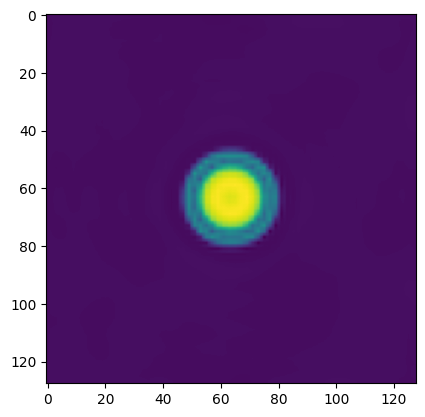

In [81]:
plt.imshow(y_rec)

In [37]:
y_rec   = np.zeros(y.shape)
y_rec_2 = np.zeros(y.shape)

for i in range(x_rec.shape[0]):
    for j in range(x_rec.shape[0]):
        xi = np.array([x_rec[i],x_rec[j]]) - A 

        # Approx
        inv_s = pow(2, scale - nb_levels)
        ks = np.array([[(k_1, k_2) for k_2 in range(LL.shape[1])] for k_1 in range(LL.shape[0])])
        idxs = get_disc_idxs(xi, ks, inv_s)
        fL_x, fL_y = fL[idxs[:,:,0]], fL[idxs[:,:,1]]
        fH_x, fH_y = fH[idxs[:,:,0]], fH[idxs[:,:,1]]

        disc_fLL = fL_x * fL_y
        disc_fLH = fL_x * fH_y
        disc_fHL = fH_x * fL_y
        disc_fHH = fH_x * fH_y

        y_rec[j, i] = k_s * sqrt(inv_s) * np.sum(LH * disc_fLH)  / sqrt(2)
        # y_rec_2[j, i] = k_s * sqrt(inv_s) * np.sum(LL * disc_fLL)  / sqrt(2)

In [76]:
rec_data = pywt.idwt2((LL, (None, None, None)), 'db2')

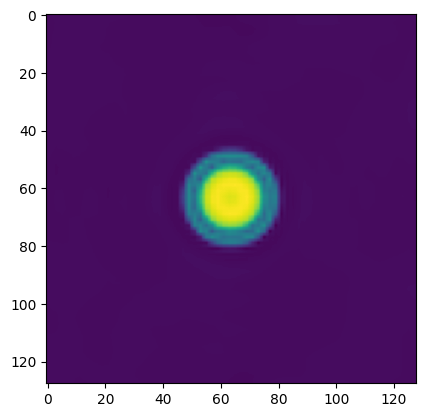

In [77]:
plt.imshow(rec_data)

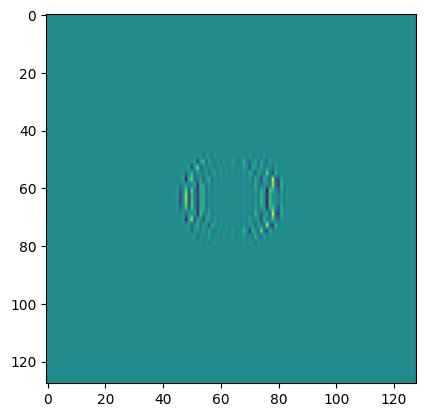

In [39]:
plt.imshow(rec_data)

In [23]:
# Generate discrete signal
scale = 7
y = yyhat[0,...,0,0].cpu().detach().numpy()
    
# Wavelet decomposition
wavelet = pywt.Wavelet('db2')
# coeffs = pywt.wavedec(y, wavelet)
coeffs = pywt.dwt2(y, 'db2')
LL, (HL, LH, HH) = coeffs # (cA, (cH, cV, cD)) XY
nb_levels = len(coeffs) - 1
    
# Upsample wavelet function + linear interpolation
fL, fH, x_wav = wavelet.wavefun(level=scale+2)

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx
        
# Reconstruct
k_s    = 1. / sqrt(pow(2, scale))
dx     = pow(2, -scale)
x_rec  = np.arange(0, 1, dx)
y_rec  = np.zeros(y.shape)

# Fixing parameters
A = 0.0105              # <<<<<<<<<<<< db2: ~0.0105
B = wavelet.rec_len - 2 # <<<<<<<<<<<<

def get_disc_f(xi_comp, ks_comp, inv_s_comp, f_comp):
    disc_fs = []
    for xi, ks, inv_s, f in zip(xi_comp, ks_comp, inv_s_comp, f_comp):
        disc_xs = inv_s * xi - ks + B
        idx_tmp = np.searchsorted(x_wav, disc_xs)
        idxs = np.clip(idx_tmp - 1, 0, len(x_wav)-1)
        disc_fs.append(f[idxs])
    return sqrt(inv_s) * disc_fs[0] * disc_fs[1]

for i_x in range(x_rec.shape[0]):
    for i_y in range(x_rec.shape[0]):
        xi = np.array([x_rec[i_x], x_rec[i_y]]) - A 

        # Approx
        inv_sL = pow(2, scale - nb_levels)
        inv_sH = pow(2, scale + 1 - nb_levels)
        kxs, kys = np.array(range(LL.shape[0])), np.array(range(LL.shape[1]))
        disc_fLL = get_disc_f(xi, [kxs, kys], [inv_sL, inv_sL], [fL, fL])
        
        # Details
        kxs, kys = np.array(range(HL.shape[0])), np.array(range(HL.shape[1]))
        disc_fHL = get_disc_f(xi, [kxs, kys], [inv_sH, inv_sL], [fH, fL])

        kxs, kys = np.array(range(LH.shape[0])), np.array(range(LH.shape[1]))
        disc_fLH = get_disc_f(xi, [kxs, kys], [inv_sL, inv_sH], [fL, fH])

        kxs, kys = np.array(range(HH.shape[0])), np.array(range(HH.shape[1]))
        disc_fHH = get_disc_f(xi, [kxs, kys], [inv_sH, inv_sH], [fH, fH])
        
        y_rec[i_x, i_y] = np.sum(LL * disc_fLL) + np.sum(HL * disc_fHL) + np.sum(LH * disc_fLH) + np.sum(HH * disc_fHH)

In [24]:
y_recon = pywt.idwt(LL, (HL, LH, HH), 'db2')

RuntimeError: C inverse wavelet transform failed

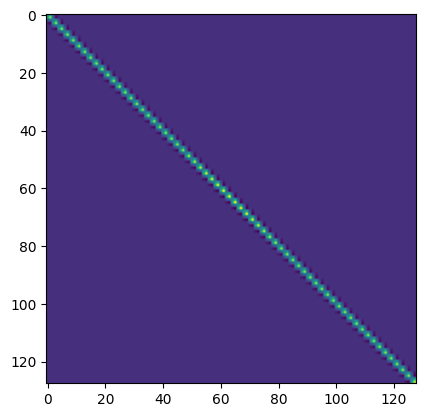

In [7]:
plt.imshow(y_rec)

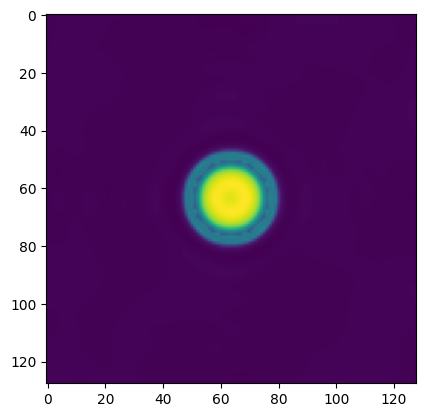

In [35]:
plt.imshow(y)

In [ ]:
# Generate discrete signal
scale = 7
y = yyhat[0,...,0,0].cpu().detach().numpy()
    
# Wavelet decomposition
wavelet = pywt.Wavelet('db2')
coeffs = pywt.dwt2(y, 'db2')
LL, (HL, LH, HH) = coeffs # (cA, (cH, cV, cD)) XY
nb_levels = len(coeffs) - 1
    
# Upsample wavelet function + linear interpolation
fL, fH, x_wav = wavelet.wavefun(level=scale+2)

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx
        
# Reconstruct
k_s    = 1. / sqrt(pow(2, scale))
dx     = pow(2, -scale)
x_rec  = np.arange(0, 1, dx)
y_rec  = np.zeros(y.shape)

# Fixing parameters
A = 0.0105              # <<<<<<<<<<<< db2: ~0.0105
B = wavelet.rec_len - 2 # <<<<<<<<<<<<

def get_disc_f(xi_comp, ks_comp, inv_s_comp, f_comp):
    disc_fs = []
    for xi, ks, inv_s, f in zip(xi_comp, ks_comp, inv_s_comp, f_comp):
        disc_xs = inv_s * xi - ks + B
        idx_tmp = np.searchsorted(x_wav, disc_xs)
        idxs = np.clip(idx_tmp - 1, 0, len(x_wav)-1)
        disc_fs.append(f[idxs])
    return sqrt(inv_s) * disc_fs[0] * disc_fs[1]

for i_x in range(x_rec.shape[0]):
    for i_y in range(x_rec.shape[0]):
        xi = np.array([x_rec[i_x], x_rec[i_y]]) - A

        # Approx
        inv_sL = pow(2, scale - nb_levels)
        inv_sH = pow(2, scale + 1 - nb_levels)
        kxs, kys = np.array(range(LL.shape[0])), np.array(range(LL.shape[1]))
        disc_fLL = get_disc_f(xi, [kxs, kys], [inv_sL, inv_sL], [fL, fL])
        
        y_rec[i_x, i_y] = np.sum(LL * disc_fLL) + np.sum(HL * disc_fHL) + np.sum(LH * disc_fLH) + np.sum(HH * disc_fHH)

In [35]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pywt
import math

In [36]:
def test_func(x):
    k1 = 5
    k2 = 20
    k = k1 + (k2 - k1) * (4 * (x-0.5)**3 + 0.5)
    return np.sin(k * x)


In [37]:
def sample_signal(test_f, scale):
    dx = pow(2, -scale)
    x = np.arange(0, 1, dx)
    y = np.array([test_f(x[i]) for i in range(x.shape[0])])
    y = test_f(x)
    return x, y

In [38]:
# Generate discrete signal
scale = 7
x, y = sample_signal(test_func, scale)
    
# Wavelet decomposition
wavelet = pywt.Wavelet('db2')
# coeffs = pywt.wavedec(y, wavelet)
coeffs = pywt.dwt(y, 'db2')
L, H = coeffs
nb_levels = len(coeffs) - 1
    
# Upsample wavelet function + linear interpolation
fL, fH, x_wav = wavelet.wavefun(level=scale+2)

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx
        
# Reconstruct
k_s = 1. / sqrt(pow(2, scale))
x_rec = x #np.arange(0, 1, dx)
y_rec = np.zeros(y.shape)
# Fixing parameters
A = 0.0105              # <<<<<<<<<<<< db2: ~0.0105
B = wavelet.rec_len - 2 # <<<<<<<<<<<<

In [45]:
def get_disc_f(xi, ks, inv_s, f):
    disc_xs = inv_s * xi - ks + B
    idx_tmp = np.searchsorted(x_wav, disc_xs)
    idxs = np.clip(idx_tmp - 1, 0, len(x_wav)-1)
    return k_s * sqrt(inv_s) * f[idxs]

for i in range(x_rec.shape[0]):
    xi = x_rec[i] - A 

    # Approx
    inv_sL = pow(2, scale - nb_levels)
    inv_sH = pow(2, scale + 1 - nb_levels)
    
    ks = np.array(range(L.shape[0]))
    disc_fL = get_disc_f(xi, ks, inv_sL, fL)
    
    # Details
    ks = np.array(range(H.shape[0]))
    disc_fH = get_disc_f(xi, ks, inv_sH, fH)
    
    y_rec[i] = L @ disc_fL# + H @ disc_fH

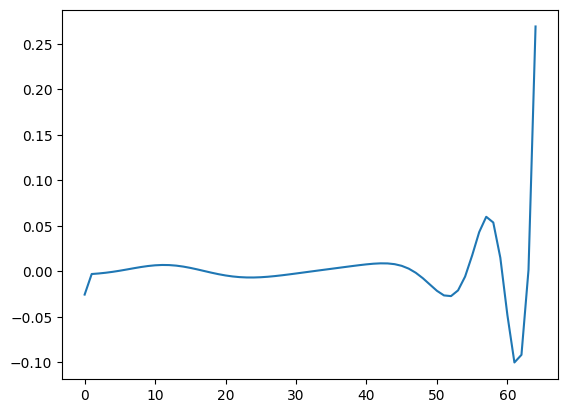

In [44]:
plt.plot(H)

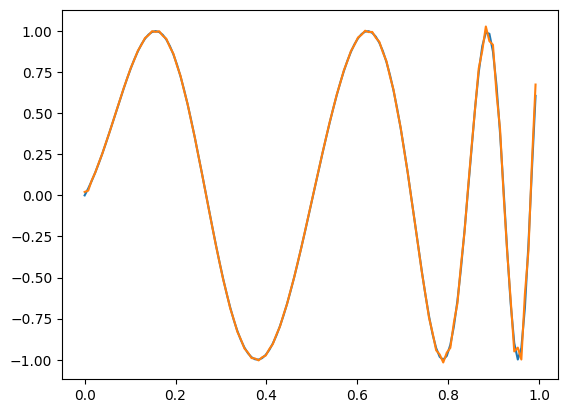

In [46]:
plt.plot(x, y)
plt.plot(x, y_rec)